## Introducing Optimization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import vertical_data
nnfs.init()

SIMPLER DATASET

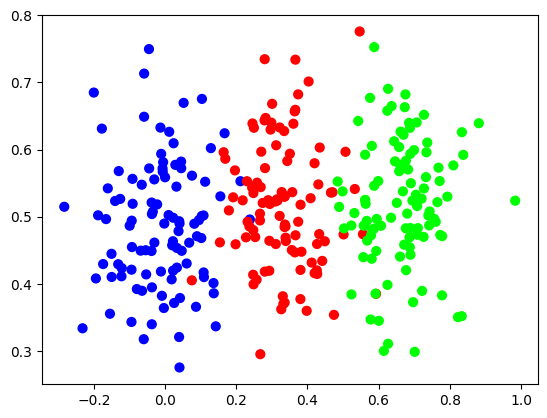

In [4]:
X, y = vertical_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

In [5]:
# Dense layer
class Layer_Dense:
    
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

# ReLU activation
class Activation_ReLU:
    
    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

# Softmax activation
class Activation_Softmax:
    
    # Forward pass
    def forward(self, inputs):
        
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
        keepdims=True))
        
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
        keepdims=True)
        
        self.output = probabilities

# Common loss class
class Loss:
    
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        
        data_loss = np.mean(sample_losses)
        
        # Return loss
        return data_loss
    
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    
    # Forward pass
    def forward(self, y_pred, y_true):
        
        # Number of samples in a batch
        samples = len(y_pred)
        
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
            range(samples),
            y_true
            ]
            
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
            y_pred_clipped * y_true,
            axis=1
        )
            
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


### STRATEGY 1: RANDOMLY SELECT WEIGHTS AND BIASES - DOES NOT WORK!

In [6]:
# Create dataset
X, y = vertical_data(samples=100, classes=3)
# Create model
dense1 = Layer_Dense(2, 3) # first dense layer, 2 inputs
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3) # second dense layer, 3 inputs, 3 outputs
activation2 = Activation_Softmax()
# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(100000):
  # Generate a new set of weights for iteration
  dense1.weights = 0.05 * np.random.randn(2, 3)
  dense1.biases = 0.05 * np.random.randn(1, 3)
  dense2.weights = 0.05 * np.random.randn(3, 3)
  dense2.biases = 0.05 * np.random.randn(1, 3)
  
  # Perform a forward pass of the training data through this layer
  dense1.forward(X)
  activation1.forward(dense1.output)
  dense2.forward(activation1.output)
  activation2.forward(dense2.output)
  
  # Perform a forward pass through activation function
  # it takes the output of second dense layer here and returns loss
  loss = loss_function.calculate(activation2.output, y)
  
  # Calculate accuracy from output of activation2 and targets
  # calculate values along first axis
  predictions = np.argmax(activation2.output, axis=1)
  accuracy = np.mean(predictions == y)
  
  # If loss is smaller - print and save weights and biases aside
  if loss < lowest_loss:
    print('New set of weights found, iteration:', iteration,'loss:', loss, 'acc:', accuracy)
    best_dense1_weights = dense1.weights.copy()
    best_dense1_biases = dense1.biases.copy()
    best_dense2_weights = dense2.weights.copy()
    best_dense2_biases = dense2.biases.copy()
    lowest_loss = loss

New set of weights found, iteration: 0 loss: 1.0987074 acc: 0.3333333333333333
New set of weights found, iteration: 7 loss: 1.0986075 acc: 0.3333333333333333
New set of weights found, iteration: 10 loss: 1.0983617 acc: 0.3333333333333333
New set of weights found, iteration: 11 loss: 1.0978478 acc: 0.3333333333333333
New set of weights found, iteration: 13 loss: 1.0962939 acc: 0.3333333333333333
New set of weights found, iteration: 221 loss: 1.0953202 acc: 0.3333333333333333
New set of weights found, iteration: 28780 loss: 1.0948828 acc: 0.64


### STRATEGY 2: RANDOMLY ADJUST WEIGHTS AND BIASES - WORKS!

In [7]:
# Create dataset
X, y = vertical_data(samples=100, classes=3)
# Create model
dense1 = Layer_Dense(2, 3) # first dense layer, 2 inputs
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3) # second dense layer, 3 inputs, 3 outputs
activation2 = Activation_Softmax()
# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10000):
    
    # Update weights with some small random values
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1, 3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1, 3)
    
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    # Perform a forward pass through activation function
    # it takes the output of second dense layer here and returns loss
    loss = loss_function.calculate(activation2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)
    
    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print('New set of weights found, iteration:', iteration,'loss:', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss
        
    # Revert weights and biases
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()

New set of weights found, iteration: 0 loss: 1.0985897 acc: 0.3333333333333333
New set of weights found, iteration: 12 loss: 1.0982163 acc: 0.09
New set of weights found, iteration: 14 loss: 1.0960544 acc: 0.3333333333333333
New set of weights found, iteration: 29 loss: 1.0941986 acc: 0.3333333333333333
New set of weights found, iteration: 30 loss: 1.0899818 acc: 0.5966666666666667
New set of weights found, iteration: 31 loss: 1.0878984 acc: 0.48
New set of weights found, iteration: 33 loss: 1.0870142 acc: 0.33666666666666667
New set of weights found, iteration: 34 loss: 1.0869936 acc: 0.3333333333333333
New set of weights found, iteration: 35 loss: 1.0848598 acc: 0.3333333333333333
New set of weights found, iteration: 37 loss: 1.0843034 acc: 0.3333333333333333
New set of weights found, iteration: 39 loss: 1.079861 acc: 0.3333333333333333
New set of weights found, iteration: 40 loss: 1.0776694 acc: 0.3333333333333333
New set of weights found, iteration: 48 loss: 1.075 acc: 0.34
New set

### Strategy 2: For Spiral Dataset - Does Not Work!

In [8]:
from nnfs.datasets import spiral_data
nnfs.init()

In [9]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create model
dense1 = Layer_Dense(2, 3) # first dense layer, 2 inputs
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3) # second dense layer, 3 inputs, 3 outputs
activation2 = Activation_Softmax()
# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10000):
    
    # Update weights with some small random values
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1, 3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1, 3)
    
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    # Perform a forward pass through activation function
    # it takes the output of second dense layer here and returns loss
    loss = loss_function.calculate(activation2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)
    
    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print('New set of weights found, iteration:', iteration,'loss:', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss
        
    # Revert weights and biases
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()

New set of weights found, iteration: 0 loss: 1.1008677 acc: 0.3333333333333333
New set of weights found, iteration: 1 loss: 1.0994315 acc: 0.3333333333333333
New set of weights found, iteration: 2 loss: 1.0991219 acc: 0.3333333333333333
New set of weights found, iteration: 3 loss: 1.0986339 acc: 0.3333333333333333
New set of weights found, iteration: 4 loss: 1.0986199 acc: 0.3333333333333333
New set of weights found, iteration: 5 loss: 1.0984716 acc: 0.36333333333333334
New set of weights found, iteration: 18 loss: 1.0983391 acc: 0.3333333333333333
New set of weights found, iteration: 27 loss: 1.0982698 acc: 0.3333333333333333
New set of weights found, iteration: 31 loss: 1.0982264 acc: 0.37333333333333335
New set of weights found, iteration: 35 loss: 1.0979562 acc: 0.3333333333333333
New set of weights found, iteration: 36 loss: 1.0977433 acc: 0.3433333333333333
New set of weights found, iteration: 37 loss: 1.0976934 acc: 0.3333333333333333
New set of weights found, iteration: 44 loss